# ACCESS salinity

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44069/status,
Dashboard: /proxy/44069/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38017,Workers: 28
Dashboard: /proxy/44069/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:45951,Total threads: 1
Dashboard: /proxy/38441/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:37089,


In [4]:
#Importing data

pathsC = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean.nc'))
pathsM = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126/*/ocean/ocean.nc'))

In [5]:
## Creating shelf mask another way

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')

In [7]:
#Time variant variables
def preprocess(ds):
    ds = ds[['salt', 'st_ocean','dzt']].sel(yt_ocean=shelf_mask['yt_ocean'])
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
#Time slicing
cont = cont.sel(time=slice('1910-01-01','1919-12-31'))
melt = melt.sel(time=slice('1910-01-01','1919-12-31'))

In [9]:
#Time invariant variables
areaC = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['area_t'].sel(xt_ocean=shelf_mask['xt_ocean'])
areaM = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126/output040/ocean/ocean_grid.nc')['area_t'].sel(xt_ocean=shelf_mask['xt_ocean'])

In [10]:
# Salinity variable
saltC = cont['salt']
saltM = melt['salt']

# Cell thickness
thikC = cont['dzt']
thikM =  melt['dzt']

## Bottom salinity

In [11]:
bottom_mask_saltC = saltC.where(~np.isfinite(saltC.shift({'st_ocean': -1})))
bottom_mask_saltC = ~np.isnan(bottom_mask_saltC)

In [12]:
bottom_mask_saltM = saltM.where(~np.isfinite(saltM.shift({'st_ocean': -1})))
bottom_mask_saltM = ~np.isnan(bottom_mask_saltM)

In [ ]:
botsalt_cont = saltC.where(bottom_mask_saltC).sum(dim='st_ocean')
botsalt_pert = saltM.where(bottom_mask_saltM).sum(dim='st_ocean')

In [ ]:
botsalt_cont = botsalt_cont.mean(dim=['xt_ocean','yt_ocean'])
botsalt_pert = botsalt_pert.mean(dim=['xt_ocean','yt_ocean'])

In [15]:
botsalt_cont = botsalt_cont.load()
botsalt_pert = botsalt_pert.load()

In [ ]:
botsalt_anom = botsalt_pert - botsalt_cont
botsalt_anom = botsalt_anom.load()

In [17]:
botsalt_anom.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/accessom201_botsalt_anom.nc')

Text(0.5, 1.0, 'ACCESS Time Series of Bottom Salinity on Shelf')

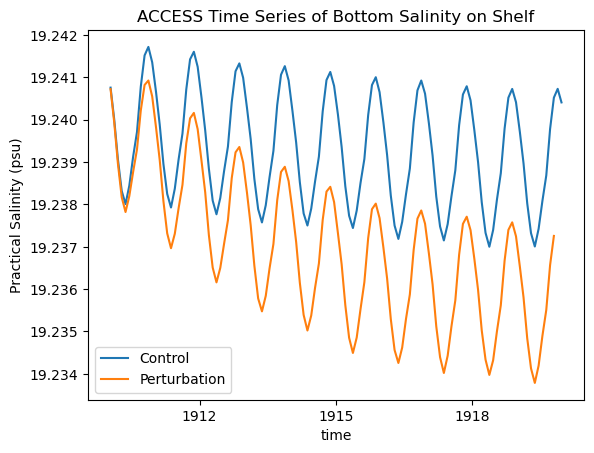

In [24]:
botsalt_cont.plot(label="Control")
botsalt_pert.plot(label="Perturbation")
#plt.xlim(380,4000)
#plt.ylim(-1.30,-0.70)
plt.ylabel("Practical Salinity (psu)")
plt.legend(loc="lower left")
plt.title("ACCESS Time Series of Bottom Salinity on Shelf")

#### Mapping bottom salinity

In [13]:
botsalt_cont_map = saltC.where(bottom_mask_saltC).sum(dim='st_ocean').mean(dim='time')
botsalt_pert_map = saltM.where(bottom_mask_saltM).sum(dim='st_ocean').mean(dim='time')
botsalt_anom_ave = botsalt_pert_map - botsalt_cont_map

In [14]:
botsalt_anom_ave = botsalt_anom_ave.load()

In [15]:
import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

In [16]:
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
projection = ccrs.SouthPolarStereo()

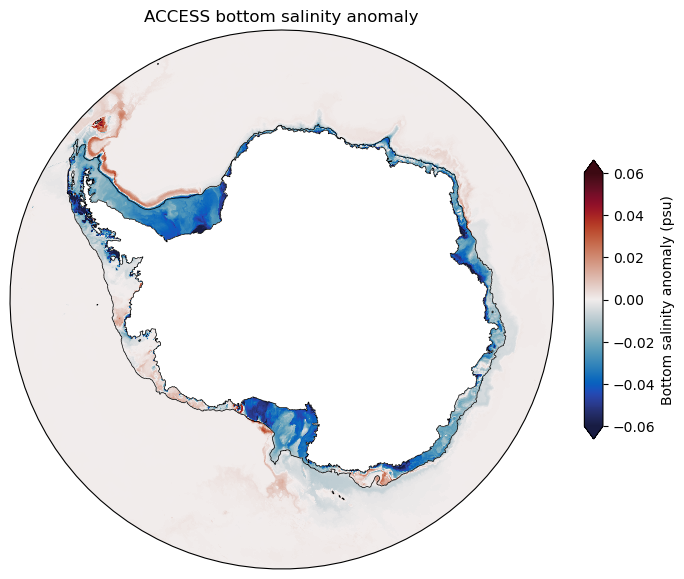

In [35]:
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Adding the model land mask
land.plot.contourf(ax=ax, x="xt_ocean", y="yt_ocean", colors="white",
    zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)

# Adding the model coastline
land.fillna(0).plot.contour(ax=ax, x="xt_ocean", y="yt_ocean", colors="k",
    levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)

# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

botsalt_anom_ave.plot(
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=-0.06,
    vmax=0.06,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Bottom salinity anomaly (psu)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("ACCESS bottom salinity anomaly");

In [ ]:
## Not using
#botsalt_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_temp_C_500time.nc', chunks = 'auto')

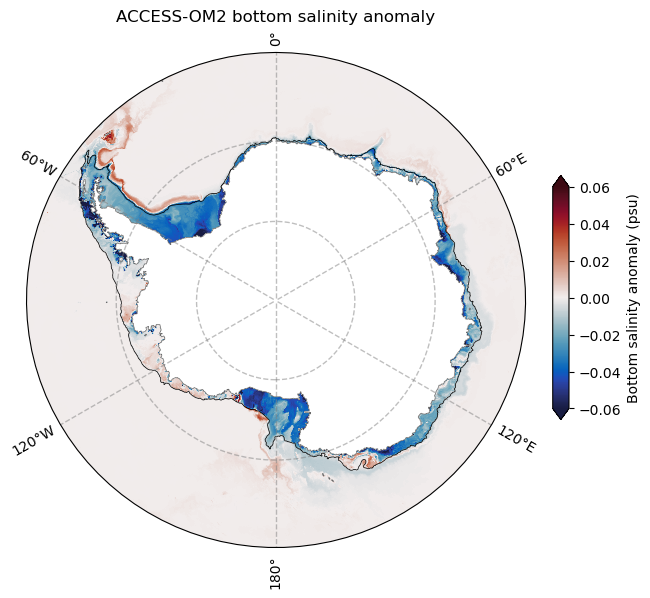

In [21]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

botsalt_anom_ave.plot(
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=-0.06,
    vmax=0.06,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Bottom salinity anomaly (psu)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("ACCESS-OM2 bottom salinity anomaly");